In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv('preprocess.csv')
df.head()

,age,sex,presure_blood_resting,colesterol,cigarettes_per_day,smoker_years,sugar,max_heart_rate,res_heart_rate,blood_presure_sistoles,...,major_vessels_1.0,major_vessels_2.0,major_vessels_3.0,electrocardio_0.0,electrocardio_1.0,electrocardio_2.0,chest_pain_1.0,chest_pain_2.0,chest_pain_3.0,chest_pain_4.0
0,63.0,1.0,145.0,233.0,50.0,20.0,1.0,150.0,60.0,190.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,67.0,1.0,160.0,286.0,40.0,40.0,0.0,108.0,64.0,160.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,67.0,1.0,120.0,229.0,20.0,35.0,0.0,129.0,78.0,140.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,37.0,1.0,130.0,250.0,0.0,0.0,0.0,187.0,84.0,195.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,41.0,0.0,130.0,204.0,0.0,0.0,0.0,172.0,71.0,160.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [4]:
n = 50
random_state = 42

X = df.loc[:, df.columns != 'prob']
y = df['prob']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)

# Apply the normalization trained in training data in both training and test sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Linear

In [5]:
#knc = LinearSVC()
knc = SVC(kernel='linear')
knc.fit(X_train, y_train)
pred = knc.predict(X_test)

print("Confusion matrix on test set:\n", sk.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ", sk.metrics.accuracy_score(y_test, pred))
print("\nF1 score on test set: ", sk.metrics.f1_score(y_test, pred, average='micro'))

Confusion matrix on test set:
 [[192   6   5   5   0]
 [ 29   9  12  12   1]
 [  4   7   4  12   0]
 [  4   8   7  16   1]
 [  0   3   4   6   2]]

Accuracy on test set:  0.6389684813753582

F1 score on test set:  0.6389684813753582


In [6]:
# List of C values to test. We usualy test diverse orders of magnitude
Cs = np.logspace(-3, 6, num=10, base=10.0)
#Cs = np.logspace(-3, 5, num=9, base=10.0)

param_grid = {'C': Cs}
#grid_search = GridSearchCV(LinearSVC(), param_grid, cv=10)
grid_search = GridSearchCV(SVC(kernel='linear'), param_grid, cv=5, n_jobs=-1, scoring='f1_micro', verbose=10)
grid_search.fit(X_train, y_train)

# Let's plot the 10-fold cross.validation accuracy deppending on C
scores = grid_search.cv_results_['mean_test_score']

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:   26.8s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:  5.5min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 42.0min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 128.0min finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1059s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


F1 score 5-fold cross on train data=  0.6704461107324093


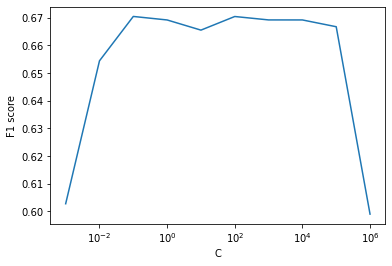

In [7]:
plt.semilogx(Cs,scores)
plt.ylabel('F1 score')
plt.xlabel('C')
plt.savefig('../figures/svm_linear_C_cv.pdf')

parval=grid_search.best_params_
cvacc = cross_val_score(SVC(C=parval['C'],kernel='linear'), X=X_train,  y=y_train, cv=5, scoring='f1_micro', n_jobs=-1, verbose=10)
print('F1 score 5-fold cross on train data= ', cvacc.mean())

# Let's apply the best C parameter found to the test set

In [8]:
#knc = LinearSVC(C=parval['C'])
svcl = SVC(C=parval['C'], kernel='linear')
svcl.fit(X_train, y_train)
pred = svcl.predict(X_test)

print("\nConfusion matrix on test set:\n", sk.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ", sk.metrics.accuracy_score(y_test, pred))
print("\nF1 score on test set: ", sk.metrics.f1_score(y_test, pred, average='micro'))
print("\nBest value of parameter C found: ", parval)
print("\nNumber of supports: ", np.sum(svcl.n_support_), "(",np.sum(np.abs(svcl.dual_coef_)==parval['C']) ,"of them have slacks)")
print("Prop. of supports: ", np.sum(svcl.n_support_)/X_train.shape[0])


Confusion matrix on test set:
 [[196   6   5   1   0]
 [ 33   8  11  11   0]
 [  7   8   3   9   0]
 [  5  12   7  12   0]
 [  0   4   2   9   0]]

Accuracy on test set:  0.6275071633237822

F1 score on test set:  0.6275071633237822

Best value of parameter C found:  {'C': 0.1}

Number of supports:  438 ( 925 of them have slacks)
Prop. of supports:  0.5387453874538746


## Poly

In [9]:
svcp2 = SVC(kernel='poly', degree=2)
svcp2.fit(X_train, y_train)

pred = svcp2.predict(X_test)
print("Confusion matrix on test set:\n",sk.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ",sk.metrics.accuracy_score(y_test, pred))

Confusion matrix on test set:
 [[197   6   4   1   0]
 [ 26  15  13   9   0]
 [  7   9   4   7   0]
 [  4  11   5  15   1]
 [  1   4   3   4   3]]

Accuracy on test set:  0.670487106017192


In [10]:
Cs = np.logspace(-3, 6, num=10, base=10.0)

param_grid = {'C': Cs}
grid_search = GridSearchCV(SVC(kernel='poly', degree=2) , param_grid, cv=5, n_jobs=-1, scoring='f1_micro', verbose=10)
grid_search.fit(X_train, y_train)

scores = grid_search.cv_results_['mean_test_score']

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0287s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:    1.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:    1.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:    1.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.9s finished


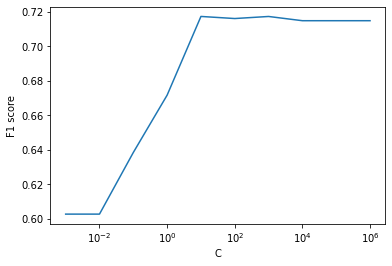

In [11]:
plt.semilogx(Cs,scores)
plt.ylabel('F1 score')
plt.xlabel('C')
plt.savefig('../figures/svm_poly_C_cv.pdf')

In [12]:
parval = grid_search.best_params_

cvacc = cross_val_score(SVC(kernel='poly', degree=2, C=parval['C']) , X=X_train,  y=y_train, cv=5, scoring='f1_micro', n_jobs=-1)
print('F1 score 5-fold cross on train data= ', cvacc.mean())

svcp2 = SVC(kernel='poly', degree=2, C=parval['C'])
svcp2.fit(X_train, y_train)
pred = svcp2.predict(X_test)

F1 score 5-fold cross on train data=  0.7171703400742254


In [13]:
print("\nConfusion matrix on test set:\n", sk.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ", sk.metrics.accuracy_score(y_test, pred))
print("\nF1 score on test set: ", sk.metrics.f1_score(y_test, pred, average='micro'))
print("\nBest combination of parameters found: ",parval)
print("\nNumber of supports: ",np.sum(svcp2.n_support_), "(",np.sum(np.abs(svcp2.dual_coef_)==parval['C']) ,"of them have slacks)")
print("Prop. of supports: ",np.sum(svcp2.n_support_)/X_train.shape[0])


Confusion matrix on test set:
 [[186  13   3   5   1]
 [ 24  30   3   6   0]
 [  3   9   7   8   0]
 [  3   6   3  22   2]
 [  0   3   4   4   4]]

Accuracy on test set:  0.7134670487106017

F1 score on test set:  0.7134670487106017

Best combination of parameters found:  {'C': 10.0}

Number of supports:  454 ( 242 of them have slacks)
Prop. of supports:  0.5584255842558425


## Poly3

In [14]:
svcp3 = SVC(kernel='poly', degree=3)
svcp3.fit(X_train, y_train)
pred = svcp3.predict(X_test)

print("Confusion matrix on test set:\n", sk.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ", sk.metrics.accuracy_score(y_test, pred))

Confusion matrix on test set:
 [[194   9   4   1   0]
 [ 27  17  10   9   0]
 [  4  10   6   7   0]
 [  5   7   4  17   3]
 [  1   2   5   3   4]]

Accuracy on test set:  0.6819484240687679


In [15]:
Cs = np.logspace(-3, 6, num=10, base=10.0)

param_grid = {'C': Cs}
grid_search = GridSearchCV(SVC(kernel='poly', degree=3) , param_grid, cv=5, n_jobs=-1, scoring='f1_micro', verbose=10)
grid_search.fit(X_train,y_train)

scores = grid_search.cv_results_['mean_test_score']

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0882s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


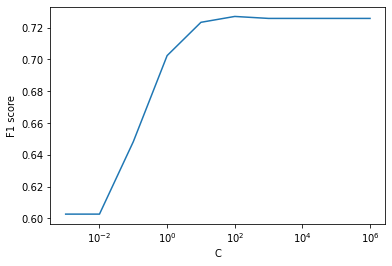

In [16]:
plt.semilogx(Cs, scores)
plt.ylabel('F1 score')
plt.xlabel('C')
plt.savefig('../figures/svm_poly3_C_cv.pdf')

In [17]:
parval = grid_search.best_params_

cvacc = cross_val_score(SVC(kernel='poly', degree=3, C=parval['C']) , X=X_train,  y=y_train, cv=5, scoring='f1_micro', n_jobs=-1)
print('F1 score 5-fold cross on train data= ', cvacc.mean())

svcp3 = SVC(kernel='poly', degree=3, C=parval['C'])
svcp3.fit(X_train, y_train)
pred = svcp3.predict(X_test)

F1 score 5-fold cross on train data=  0.7270165871392864


In [18]:
print("\nConfusion matrix on test set:\n", sk.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ", sk.metrics.accuracy_score(y_test, pred))
print("\nF1 score on test set: ", sk.metrics.f1_score(y_test, pred, average='micro'))
print("\nBest combination of parameters found: ", parval)
print("\nNumber of supports: ",np.sum(svcp3.n_support_), "(",np.sum(np.abs(svcp3.dual_coef_)==parval['C']) ,"of them have slacks)")
print("Prop. of supports: ",np.sum(svcp3.n_support_)/X_train.shape[0])


Confusion matrix on test set:
 [[187   9   4   7   1]
 [ 28  28   4   3   0]
 [  4   5   9   8   1]
 [  6   4   5  20   1]
 [  2   0   4   3   6]]

Accuracy on test set:  0.7163323782234957

F1 score on test set:  0.7163323782234956

Best combination of parameters found:  {'C': 100.0}

Number of supports:  443 ( 18 of them have slacks)
Prop. of supports:  0.5448954489544895


## RBF Kernel

In [19]:
svcrbf = SVC()
svcrbf.fit(X_train, y_train)
pred = svcrbf.predict(X_test)
print("Confusion matrix on test set:\n", sk.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ", sk.metrics.accuracy_score(y_test, pred))

Confusion matrix on test set:
 [[200   5   3   0   0]
 [ 28  12  12  11   0]
 [  7   8   4   8   0]
 [  8   8   6  14   0]
 [  1   4   4   5   1]]

Accuracy on test set:  0.66189111747851


In [20]:
# Values we will test for each parameter. When observing results, consider the limits of the
# values tested and increase them if necessary
gammas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
Cs = np.logspace(-1, 6, num=8, base=10.0)

param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, scoring='f1_micro', verbose=10)
grid_search.fit(X_train,y_train)
parval=grid_search.best_params_

# We'll show in a grid, the accuracy for each combination of parameters tester
scores = grid_search.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(param_grid['C']), len(param_grid['gamma']))

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0328s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1436s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 264 out of 320 | elapsed:    1.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    4.1s finished



Best combination of parameters found:  {'C': 10.0, 'gamma': 1}

F1 score 5-fold cross on train data=  0.7404756494736044


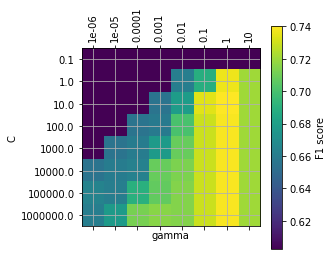

In [21]:
plt.matshow(scores)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar(label='F1 score')
plt.grid(b=None)
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation='vertical')
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'])
plt.savefig("../figures/svm_rbf_C_cv.pdf")

parval = grid_search.best_params_
print("\nBest combination of parameters found: ", parval)

cvacc = cross_val_score(SVC(C=parval['C'], gamma=parval['gamma']) , X=X_train,  y=y_train, cv=5, scoring='f1_micro', n_jobs=-1)
print('\nF1 score 5-fold cross on train data= ', cvacc.mean())

In [22]:
svcrbf = SVC(C=parval['C'], gamma=parval['gamma'])
svcrbf.fit(X_train, y_train)
pred = svcrbf.predict(X_test)

print("Confusion matrix on test set:\n", sk.metrics.confusion_matrix(y_test, pred))
print("\nAccuracy on test set: ", sk.metrics.accuracy_score(y_test, pred))
print("\nF1 score on test set: ", sk.metrics.f1_score(y_test, pred, average='micro'))
print("\nNumber of supports: ",np.sum(svcrbf.n_support_), "(",np.sum(np.abs(svcrbf.dual_coef_)==parval['C']) ,"of them have slacks)")
print("Prop. of supports: ",np.sum(svcrbf.n_support_)/X_train.shape[0])

Confusion matrix on test set:
 [[199   3   2   4   0]
 [ 39  22   2   0   0]
 [  8   4   9   5   1]
 [ 17   1   2  16   0]
 [  6   0   1   3   5]]

Accuracy on test set:  0.7191977077363897

F1 score on test set:  0.7191977077363897

Number of supports:  545 ( 2 of them have slacks)
Prop. of supports:  0.6703567035670357
